In [1]:
import random, numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
alphap = 2
probp = 0.75
expon = 2 * alphap - 1
ensemble_sizep = 50_000
min_iterationp = 100_000
bin_sizep = 0.0001
filename = "../../data/alpha3/function_phi_alpha3_dataframe.csv"

In [3]:
def betadist(alpha):
    """gives a random number from beta distribution"""
    return random.betavariate(alpha,alpha)

In [4]:
def decision(probability):
    """
    decides with a given probability whether to keep the right part
    """
    if float(probability) > random.random():
        return float(1)
    else: 
        return float(0)

In [5]:
def splitting(segment):
    """
    splits a given segment. left and right are endpoints of the segment
    returns : 
        xL -> length of the left segment
        xR -> length of the right segment
        flag -> keeping the right segment
        xLp, xRp -> probability(unnormalized) for being selected
        change -> change of normalization const
    """
    xL = segment * betadist(alphap)
    flag = decision(probp)
    xR = (segment - xL) * flag
    xLp = xL**expon
    xRp = xR**expon
    change = xLp + xRp - segment**expon
    
    return xL, xR, xLp, xRp, change

In [6]:
def pickindex(frac_prob, frac_sum):
    """
    picks up a segment to be subsequently split
    """
    r = random.uniform(0,1)
    
    if r <= frac_sum:
        sum_ = 0
        for index in range(len(frac_prob)):
            sum_ += frac_prob[index]
            if sum_ < r:
                continue
            else:
                return index

In [7]:
def number_length(lengths):
    
    N = 0
    M = 0

    for i in lengths:
        if i != float(0):
            N += 1
            M += i
            pass
        pass
    return N, M

In [8]:
def bin_maker(max_value, bin_number):
    bin_size = max_value/bin_number
    bins = [0.]
    for i in range(bin_number):
        bin_edge = (i+1)*bin_size
        bins.append(bin_edge)
        pass
    return bins

In [9]:
def realization_value(total_iteration):
    
    lengths = [1.]
    frac_prob = [1.] # raw probability, not normalized
    frac_sum = 1.0
    
    for i in range(total_iteration + 1):
        
        index = pickindex(frac_prob, frac_sum)
        
        if index != None:

            xL, xR, xLp, xRp, change = splitting(lengths[index])
            
            lengths[index] = xL
            frac_prob[index] = xLp 
            
            if xR != float(0):
                lengths.append(xR)
                frac_prob.append(xRp)
            
            frac_sum += change
            pass
        
    lengths = np.array(lengths)

    return lengths

In [10]:
def ensembling(total_iteration, ensemble_size):

    C_ensemble = np.array([])
    
    for i in range(ensemble_size):
        lengths = realization_value(total_iteration)
        C_ensemble = np.append(C_ensemble, lengths)
        pass
    
    return C_ensemble

In [11]:
import scipy.special as sc

n_star = np.linspace(0,1,1_000_001)

def func_trans(n_star,alpha,p):
    """left-hand side of transcendental equation defined as a numpy array"""
    return (sc.gamma(n_star+alpha)*sc.gamma(2*alpha))/(sc.gamma(n_star+2*alpha)*sc.gamma(alpha))-1/(1+p)

In [12]:
def find_df(alpha,p):
    """root finding by minimizing the cost function: square of left-hanad side"""
    cost_array = func_trans(n_star,alpha,p)**2
    min_index = np.argmin(cost_array)
    df_value = n_star[min_index]
    #df_rounded = float("{:.6f}".format(df_value))
    #return df_rounded
    return df_value

In [13]:
import decimal as dc
dc.getcontext().rounding = dc.ROUND_DOWN

def phi_value_alpha_3(df_data,xi,p):
    """
    df_data : pandas DataFrame
    xi      :
    p       : probablity
    """
    
    p_0 = float(round(dc.Decimal(p),2))
    p_1 = float(round(dc.Decimal(p_0+0.01),2))
    del_p = abs(p-p_0)
    
    if del_p <= 1e-9:
        col_name = 'p={:.2f}'.format(p_0)
        phi_list = df_data[col_name].values
    
    else:
        col_name0 = 'p={:.2f}'.format(p_0)
        phi_list0 = df_data[col_name0].values
    
        col_name1 = 'p={:.2f}'.format(p_1)
        phi_list1 = df_data[col_name1].values
        
        del_phi_list =  (phi_list1 - phi_list0)*del_p/0.01
        phi_list = phi_list0 + del_phi_list
    
    xi_list = df_data['xi'].values
    if xi > 2:
        phi_value = 0
    elif xi in xi_list:
        index = list(xi_list).index(xi)
        phi_value = phi_list[index] 
    else:
        index0 = int(xi//0.0002)
        index1 = int(index0+1)
        del_xi = xi%0.0002
        phi_0 = phi_list[index0]
        phi_1 = phi_list[index1]
        del_phi = (phi_1-phi_0)*del_xi/0.0002
        phi_value = phi_0 + del_phi

    return phi_value

def phi_list_alpha_3(df_data,xi_list,p):
    phi_list = []
    for xi in xi_list:
        phi_value = phi_value_alpha_3(df_data,xi,p)
        phi_list.append(phi_value) 

    return np.array(phi_list) 

In [14]:
def phi_list(alpha,p,xi_list):
    df = find_df(alpha,p)
    
    if alpha == 1:
        density = np.exp(-xi_list)
    
    elif alpha == 2:
        c2 = -(sc.gamma(1/3)/sc.gamma(5/3))*(sc.gamma((df+5)/3)/sc.gamma((df+3)/3))
        density1 = -3*(df+2)*(xi_list**2)*sc.hyp1f1(-(df-1)/3, 4/3, -xi_list**3)
        density2 = -(3/5)*c2*df*(xi_list**4)*sc.hyp1f1(-(df-3)/3, 8/3, -xi_list**3)
        density3 = -2*c2*(xi_list)*sc.hyp1f1(-df/3, 5/3, -xi_list**3)
        density = density1 + density2+ density3
    
    elif alpha == 3:
        df_data = pd.read_csv(filename)
        density = phi_list_alpha_3(df_data,xi_list,p)
            
    else:
        print('the analytical solution for alpha = {} value is unknown'.format(alpha))
        
    return density

In [15]:
def histrogram_data(data, bin_size = bin_sizep):
    bin_number = int((np.max(data) - np.min(data))//bin_size) + 1
    y, x = np.histogram(data, bins = bin_number)
    return x[1:], y

In [16]:
def fitting_parameter(given_array,ref_array):
    a1 = np.multiply(given_array,ref_array)
    a2 = np.multiply(given_array,given_array)
    a1_sum = np.sum(a1)
    a2_sum = np.sum(a2)
    return a1_sum, a2_sum

In [17]:
# ens_10k = ensembling(10_000, ensemble_sizep)
# x1, y1 = histrogram_data(ens_10k)
# ens_20k = ensembling(20_000, ensemble_sizep)
# x2, y2 = histrogram_data(ens_20k)
# ens_30k = ensembling(30_000, ensemble_sizep)
# x3, y3 = histrogram_data(ens_30k)

In [18]:
def plot_data(total_iteration):
    df = find_df(alphap,probp)
    ens_data = ensembling(total_iteration, ensemble_sizep)
    x,y = histrogram_data(ens_data)
    xi = x*total_iteration**(1/(2*alphap-1))
    phi = y/(total_iteration**((1+df)/(2*alphap-1)))
    phi_analytic = phi_list(alphap,probp,xi)
    a1_sum, a2_sum = fitting_parameter(phi,phi_analytic)
    return xi, phi, a1_sum, a2_sum

In [19]:
data_dict = {}
a1_sum, a2_sum = 0,0
for i in range(3):
    time_t = min_iterationp*(i+1)
    xi, phi, a1, a2 = plot_data(time_t)
    data_dict[time_t]=[xi,phi]
    a1_sum += a1
    a2_sum += a2
    
for i in range(3):
    time_t = min_iterationp*(i+1)
    data_dict[time_t][1]*=(a1_sum/a2_sum)

In [20]:
signature = 'data_collapse_alpha_{}_t_{}k'
for i in range(3):
    time_t = min_iterationp*(i+1)
    x,y = data_dict[time_t]
    file_name = signature.format(alphap, int(time_t//1000))
    np.savetxt(file_name,np.c_[x,y])

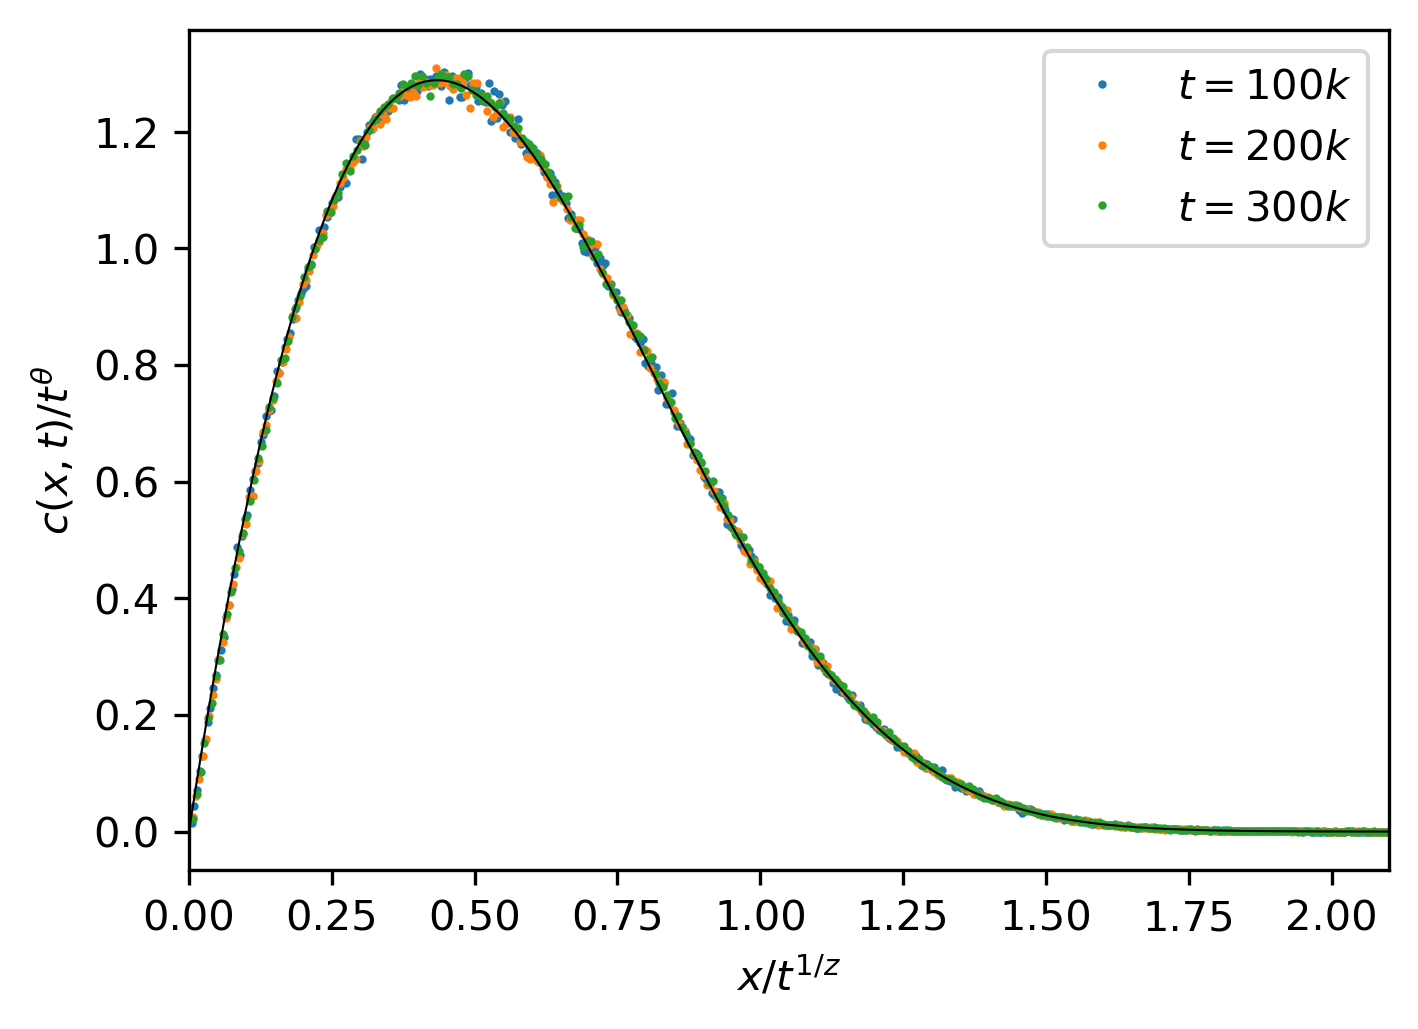

In [21]:
fig, axes = plt.subplots(1,1,figsize = (5,3.5),dpi = 300)

for i in range(3):
    time_t = min_iterationp*(i+1)
    x,y = data_dict[time_t]
    plt.plot(x, y,"o", markersize=1,label=r"$t={}k$".format(str(int(time_t//1000))))

xi_th = np.linspace(0,2.1,10501)
phi_th = phi_list(alphap,probp,xi_th)
plt.plot(xi_th,phi_th,color='black',linewidth=0.5)

plt.legend(loc=1)
plt.xlabel(r"$x/t^{1/z}$")
plt.ylabel(r"$c(x,t)/t^\theta$")
plt.xlim([0, 2.1])
axes.set_position([0.15, 0.15, 0.8, 0.8])

#plt.savefig("pn_data_coll_alpha_2.pdf")